<a href="https://colab.research.google.com/github/medhanies/hands_on_ml/blob/main/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving MNIST dataset with a Classification Model

# Load the Data

In [2]:
# load the MNIST dataset with sci-kit
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [5]:
# 70000 images with 784 features
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

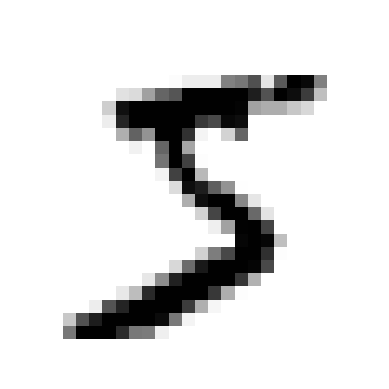

In [11]:
# show a single image
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28) # reshape to 28x28 array
  plt.imshow(image, cmap="binary") # get grayscale image
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [12]:
# first image is classified as a number 5
y[0]

'5'

# Split the Data into Train/Test

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [23]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Train a Binary Classifier

In [24]:
# only find #5 so 5 and not-5
y_train_5 = (y_train == '5') # true for all 5's, false for all other digits
y_test_5 = (y_test == '5')

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [36]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

# Measuring Accuracy using Cross Validation

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [38]:
# dummy classifier which classifies every single image in most frequent class (not-5)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints false: no 5's detected

False


In [39]:
# accuracy of dummy classifer
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# only 10% of images are '5' so you will be right 90% of time when classify non-5's

array([0.90965, 0.90965, 0.90965])

# Measuring Accuracy with Confusion Matrices

In [40]:
# before computing confusion matrix, first need predictions that can be compared to the actual targets
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

# Precision and Recall

precision = TP / (TP + FP)

recall = TP / (TP + FN)

In [42]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [43]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

F1 = 2 * (precision*recall)/(precision+recall)

In [44]:
# Combine precision and recall into 1 score called the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [47]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [49]:
# raising threshold decreases recall
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [51]:
# how to decide which threshold to use?
# return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [52]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

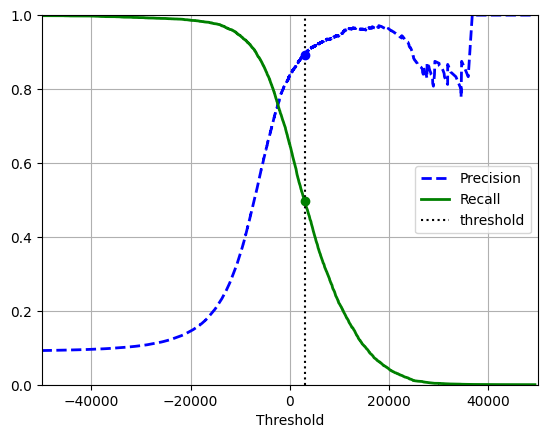

In [60]:
# threshold of 3000 illustrated
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.legend(loc="center right")
plt.xlabel("Threshold")
plt.grid()
plt.show()

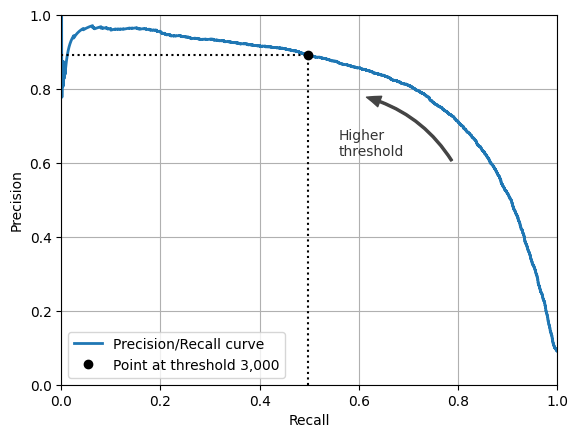

In [66]:
# plot precision directly against recall
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

plt.grid()
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])

plt.show()

In [67]:
# aim for 90% precision using argmax function to find first true value
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [68]:
# make predictions on training set
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [69]:
# recall when precision is 90%
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

# The ROC Curve

In [70]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

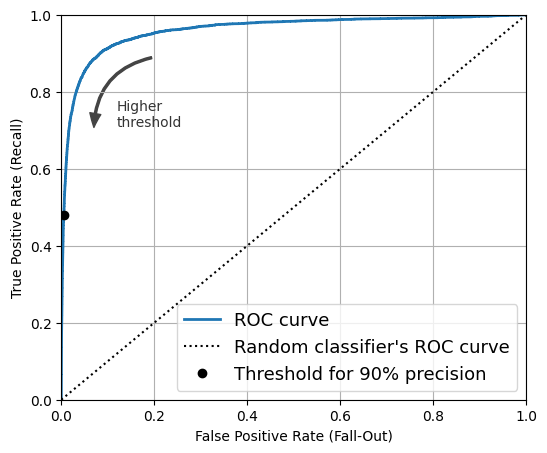

In [72]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [73]:
# find area under curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [75]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [76]:
# class probabilities of first 2 images in training set
# first image is positive with 89% probability
# second image is negative with 99% probability
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [77]:
# pass second column from random forest
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

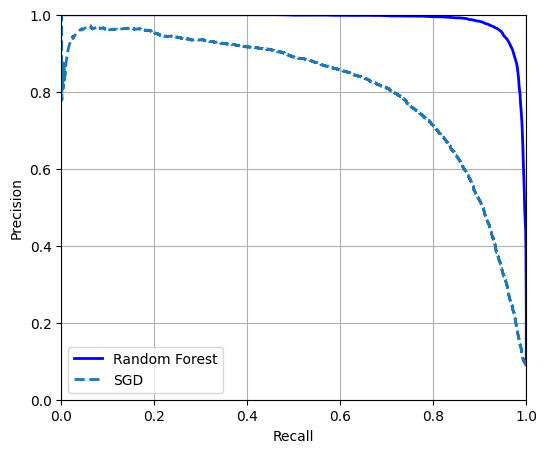

In [78]:
# plot the precision / recall curve
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()


In [80]:
# f1 score random forest
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba >= 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [81]:
# roc auc score of random forest
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [82]:
# use svm classifier to train on 2000 images
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [84]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [85]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])